In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast

#### Merge Titles and descriptions that we have parsed

In [ ]:
titles_parquet = pd.read_parquet('Titles.parquet')
titles_description = pd.read_csv("Titles_descr.csv")

In [ ]:
merge = titles_description.merge(titles_parquet, how="inner", on="id")

In [ ]:
merge_not_nun = merge[merge['description'].notna()]
merge_not_nun = merge_not_nun[merge_not_nun['title'].notna()]

In [ ]:
titles = merge_not_nun.title.values
origin_titles = merge_not_nun.origin_title.values

In [ ]:
for idx, origin_title in enumerate(origin_titles):
    if origin_title is None:
        if titles[idx] is not None:
            origin_titles[idx] = titles[idx]
            
merge_not_nun['origin_title'] = origin_titles

Picking out the title, overview, genres and movie id from the original csv. The ID was used to find the exact movie poster on IMDB to download.

In [ ]:
filtered_data = merge_not_nun.filter(['origin_title','description', 'id', 'genres'], axis=1)

In [2]:
genres = filtered_data['genres'].tolist()

invalid_genres = ['Game-Show', 'Adult', 'News', 'Reality-TV',
                  '\\N', 'Talk-Show']

supported_genres = ['Action', 'Adventure', 'Animation', 'Biography','Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
                    'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

genre_per_movie = []
genre_dict = {}

  #print(genre)
  #genre = ast.literal_eval(genre)
  genre_list = genre.split(',')
  #print(genre_list)
  for val in genre_list:
    if val not in invalid_genres:
      if val in genre_dict:
        genre_dict[val] += 1
      else:
        genre_dict[val] = 1
  genre_per_movie.append(genre_list)


genre_dict = {key:val for key, val in genre_dict.items()}
genre_dict


{'Drama': 66218,
 'Short': 12431,
 'Documentary': 16409,
 'Comedy': 43119,
 'Horror': 14934,
 'Crime': 15480,
 'Mystery': 7464,
 'Action': 18107,
 'Musical': 3195,
 'Animation': 7394,
 'Music': 3901,
 'Biography': 4893,
 'History': 4188,
 'Family': 8216,
 'Fantasy': 5727,
 'Sci-Fi': 5265,
 'Romance': 17736,
 'Adventure': 10586,
 'Thriller': 15817,
 'Sport': 2044,
 'Western': 3476,
 'War': 3207,
 'Film-Noir': 722}

In [ ]:
# Add paths to images to further usage
import os

ROOT_DIR = '/Users/annadosenko/Study/IndustrialML/2Lab/img'

poster_paths = []
ids = filtered_data.id.values
for id in ids:
    poster_path = f"{ROOT_DIR}/{id}.jpg"
    if not os.path.exists(poster_path):
        print('ERROR!', id)
        poster_paths.append("Error")
    else:
        poster_paths.append(poster_path)

print(f"Len of poster paths: {len(poster_paths)}")

filtered_data['poster_paths'] = poster_paths

filtered_data.to_csv("Dataset_movies.csv", index=False)

In [ ]:
genres_filtered_data = filtered_data.genres.values
genres_list_filtered_data = filtered_data.genre_list.values

genres_filtered_data_copy = genres_filtered_data.copy()
genres_list_filtered_data_copy = genres_list_filtered_data.copy()

genres_list_filtered_data_copy = list(genres_list_filtered_data_copy)

genres_filtered_data_copy = list(genres_filtered_data_copy)



### Get rid of unnesessary genres and drop rows if row become empty

In [ ]:
cnt = 0

for idx, genre in enumerate(genres_filtered_data_copy):
    split_genre = genre.split(',')
    for ganr in split_genre:
        if ganr not in supported_genres:
            split_genre.remove(ganr)
            print(f"Wrong ganre: {ganr}")
    if len(split_genre) == 0:
        print('Deleting', idx)
        filtered_data = filtered_data.drop(idx, axis=0)
        genres_filtered_data_copy.pop(idx)
        genres_list_filtered_data_copy.pop(idx)
        cnt += 1
    else:
        genres_filtered_data_copy[idx] = ','.join(split_genre)
        genres_list_filtered_data_copy[idx] = split_genre
        
filtered_data['genres'] = genres_filtered_data
filtered_data['genre_list'] = genres_list_filtered_data

In [ ]:
for idx, genre in enumerate(genres_filtered_data):
    split_genre = genre.split(',')
    for ganr in split_genre:
        if ganr not in supported_genres:
            filtered_data = filtered_data.drop(idx, axis=0)
            continue

In [ ]:
filtered_data.to_csv("/Users/annadosenko/Study/IndustrialML/2Lab/Dataset_movies_final_again.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(filtered_data, test_size=0.2)
train, val = train_test_split(train, test_size=0.1)
print(type(train), type(test), type(val))

In [ ]:
val.to_csv("val_data.csv", index=False)
test.to_csv("test_data.csv", index=False)
train.to_csv("train_data.csv", index=False)

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import numpy as np
import pickle
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from string import punctuation
from gensim.models import KeyedVectors

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alyaatmaeva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
dataset = pd.read_csv("Dataset_movies_final_again.csv")
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
val_data = pd.read_csv("val_data.csv")

Converting each cell of the genre list column into a list.

In [35]:
dataset['genre_list'] = dataset['genre_list'].apply(lambda x: ast.literal_eval(x))
train_data['genre_list'] = train_data['genre_list'].apply(lambda x: ast.literal_eval(x))
test_data['genre_list'] = test_data['genre_list'].apply(lambda x: ast.literal_eval(x))
val_data['genre_list'] = val_data['genre_list'].apply(lambda x: ast.literal_eval(x))

In [36]:
labels = {}

for genre in test_data['genre_list']:
  if len(genre) in labels:
    labels[len(genre)] += 1
  else:
    labels[len(genre)] = 1

labels

{2: 9406, 1: 10294, 3: 9589}

In [37]:
labels = {}

for genre in train_data['genre_list']:
  if len(genre) in labels:
    labels[len(genre)] += 1
  else:
    labels[len(genre)] = 1

labels

{3: 35219, 2: 33427, 1: 36793}

In [38]:
labels = {}

for genre in val_data['genre_list']:
  if len(genre) in labels:
    labels[len(genre)] += 1
  else:
    labels[len(genre)] = 1

labels

{3: 3948, 2: 3740, 1: 4028}

# Text cleaning

In [39]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stop.extend(['der', 'die', 'das', 'del', "don't", 'und', 'dos', 'Inc', 'mit', 'dem'])

def clean_text(text):
  text = text.translate(str.maketrans('', '', punctuation))
  text = text.lower().strip()
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()])
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])
  text = re.sub(r"\s{2,}", " ", text)
  return text

train_data['description'] = train_data['description'].astype(str)
test_data['description'] = test_data['description'].astype(str)
val_data['description'] = val_data['description'].astype(str)

train_data['origin_title'] = train_data['origin_title'].astype(str)
test_data['origin_title'] = test_data['origin_title'].astype(str)
val_data['origin_title'] = val_data['origin_title'].astype(str)

train_data['description'] = train_data['description'].apply(lambda text: clean_text(text))
test_data['description'] = test_data['description'].apply(lambda text: clean_text(text))
val_data['description'] = val_data['description'].apply(lambda text: clean_text(text))

train_data['origin_title'] = train_data['origin_title'].apply(lambda text: clean_text(text))
test_data['origin_title'] = test_data['origin_title'].apply(lambda text: clean_text(text))
val_data['origin_title'] = val_data['origin_title'].apply(lambda text: clean_text(text))

dataset['description'] = dataset['description'].astype(str)
dataset['description'] = dataset['description'].apply(lambda text: clean_text(text))

dataset['origin_title'] = dataset['origin_title'].astype(str)
dataset['origin_title'] = dataset['origin_title'].apply(lambda text: clean_text(text))

In [ ]:
dataset.to_csv("/Users/annadosenko/Study/IndustrialML/2Lab/Dataset_movies_final_clean.csv", index=False)
train_data.to_csv("/Users/annadosenko/Study/IndustrialML/2Lab/train_data_clean.csv", index=False)
test_data.to_csv("/Users/annadosenko/Study/IndustrialML/2Lab/test_data_clean.csv", index=False)
val_data.to_csv("/Users/annadosenko/Study/IndustrialML/2Lab/val_data_clean.csv", index=False)

For films description

In [40]:
cnt = 0
wordfreq_descr = dict()

# creating bag of words with frequences (one approach of calculating the frequences)
for idx, row in dataset.iterrows():
    sentence = row['description']
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        # skip the words which length is shorter than 3 symols
        if len(token) <= 2:
            continue
        if token not in wordfreq_descr.keys():
            wordfreq_descr[token] = 1
        else:
            wordfreq_descr[token] += 1
    if cnt %100 == 0:
        print(cnt)
    cnt += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

# Analysis

## Word frequency

In [9]:
import operator

# sort the dict
sorted_dict = dict(sorted(  wordfreq_descr.items(), key=operator.itemgetter(1), reverse=True))
print( list(sorted_dict.items())[:100]) # print 100 most popular with frequences

[('read', 25940), ('life', 23916), ('young', 17753), ('one', 15597), ('man', 15087), ('find', 14513), ('woman', 14396), ('love', 13924), ('two', 13312), ('story', 12954), ('get', 12399), ('family', 12001), ('friend', 11537), ('film', 10877), ('new', 10691), ('girl', 10139), ('year', 10019), ('take', 10002), ('world', 9829), ('father', 8048), ('time', 7225), ('day', 6876), ('wife', 6822), ('make', 6331), ('meet', 6305), ('try', 6250), ('old', 6235), ('home', 6199), ('come', 6170), ('fall', 6042), ('three', 6039), ('son', 5979), ('group', 5955), ('people', 5894), ('town', 5877), ('mother', 5772), ('war', 5759), ('boy', 5705), ('daughter', 5695), ('help', 5669), ('set', 5546), ('must', 5512), ('way', 5376), ('back', 5232), ('work', 5217), ('brother', 5107), ('school', 5101), ('first', 5012), ('death', 4968), ('murder', 4910), ('city', 4859), ('child', 4787), ('turn', 4649), ('documentary', 4632), ('becomes', 4589), ('want', 4571), ('house', 4398), ('small', 4244), ('return', 4159), ('nigh

In [10]:
# another approach of calculating frequences with creating a list of existing tokens exclusing words with less than 3 symbols
tokens_list_description = []
for idx, row in dataset.iterrows():
    sentence = row['description']
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        # skip the words which length is shorter than 3 symols
        if len(token) <= 2:
            continue
        tokens_list_description.append(token)

In [11]:
# calculate frequences of words (another approach)
fdist_filtered_description = nltk.FreqDist(tokens_list_description)

Text(0.5, 1.0, 'Most common words in films descriptions')

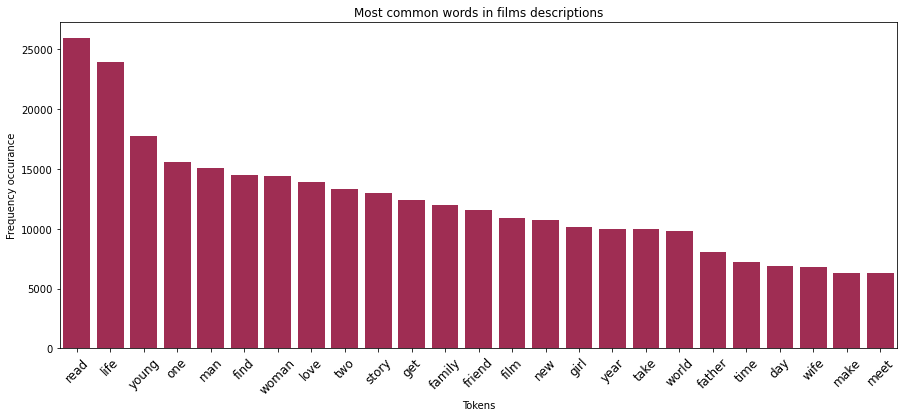

In [17]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = fdist_filtered_description.most_common(25)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15,6))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax, color=(0.7, 0.1, 0.3, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Frequency occurance')
plt.xlabel('Tokens')
plt.title('Most common words in films descriptions')

In [20]:
wordcloud_description = WordCloud(width = 1000, height = 500,background_color="white").generate_from_frequencies(fdist_filtered_description)

Top words from the descriptions

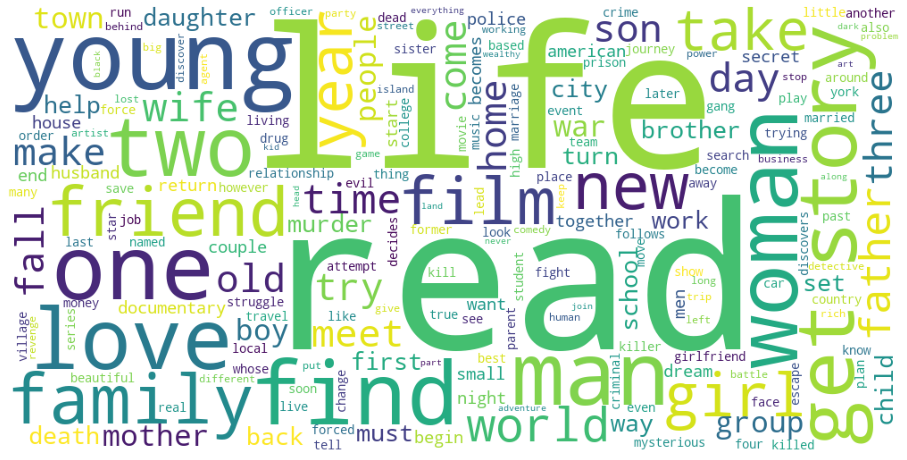

In [22]:
plt.figure(figsize=(16,10))
plt.imshow(wordcloud_description)
plt.axis("off")
plt.show()
plt.close()

In [27]:
dataset

,description,id,genres,genre_list,poster_paths,origin_title
0,bruno young university student dealing lonelin...,7773068,"Drama,Short","[Drama, Short]",/Users/annadosenko/Study/IndustrialML/2Lab/img...,noite estava fria
1,ever felt ashamed come maciej suppresses sexua...,12615984,Short,[Short],/Users/annadosenko/Study/IndustrialML/2Lab/img...,suit weareth man
2,inspired jacques tati ad japanese cell phone,12753128,Short,[Short],/Users/annadosenko/Study/IndustrialML/2Lab/img...,softbank commercial
3,mozambique one highest rate childhood drowning...,19796462,"Documentary,Short","[Documentary, Short]",/Users/annadosenko/Study/IndustrialML/2Lab/img...,guinjata bay
4,desperate son reconnects estranged father ask ...,4702552,"Comedy,Short","[Comedy, Short]",/Users/annadosenko/Study/IndustrialML/2Lab/img...,reasonable request
...,...,...,...,...,...,...
146439,two high school kid mentored nightclub owner g...,3291632,"Adventure,Comedy,Crime","[Adventure, Comedy, Crime]",/Users/annadosenko/Study/IndustrialML/2Lab/img...,school special
146440,hage holy spirit writing musical jesus return ...,1428436,Comedy,[Comedy],/Users/annadosenko/Study/IndustrialML/2Lab/img...,
146441,mysterious absence joe patrick obrien return h...,2947308,"Fantasy,Mystery","[Fantasy, Mystery]",/Users/annadosenko/Study/IndustrialML/2Lab/img...,know
146442,tom jack death becky jill continue journey zom...,7001376,Horror,[Horror],/Users/annadosenko/Study/IndustrialML/2Lab/img...,plague biohazard blood


Top words from the descriptions by genres

In [55]:
df_new = dataset.assign(genres_string=dataset['genres'].str.split(',')).explode('genres')
df_new['cnt_genres'] = df_new.genre_list.apply(lambda x: len(x) )
df_new = df_new[df_new['cnt_genres'] == 1]
df_new = df_new.explode('genres_string')

# another approach of calculating frequences with creating a list of existing tokens exclusing words with less than 3 symbols
genres_list =  ['Comedy', 'Horror', 'Crime', 'Mystery', 'Adventure','Documentary', 'Family', 'Drama', 'Action']
tokens_list_description = []
fdist_filtered_description = []
for genre in genres_list:
    print(genre)
    df = df_new[df_new['genres'] == genre]
    for idx, row in df.iterrows():
        sentence = row['origin_title']
        tokens = nltk.word_tokenize(sentence)
        for token in tokens:
            if token == 'der' or token == 'die' or token == 'das' or token == 'del':
                continue
            # skip the words which length is shorter than 3 symols
            if len(token) <= 2:
                continue
            tokens_list_description.append(token)
# calculate frequences of words (another approach)
    fdist_filtered_description.append(nltk.FreqDist(tokens_list_description))

Comedy
Horror
Crime
Mystery
Adventure
Documentary
Family
Drama
Action


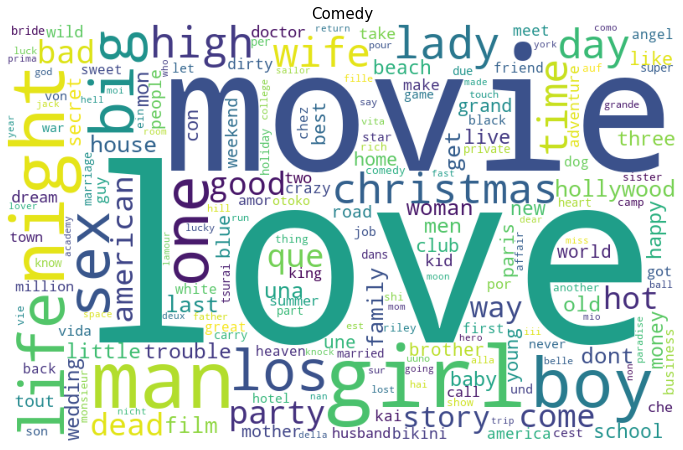

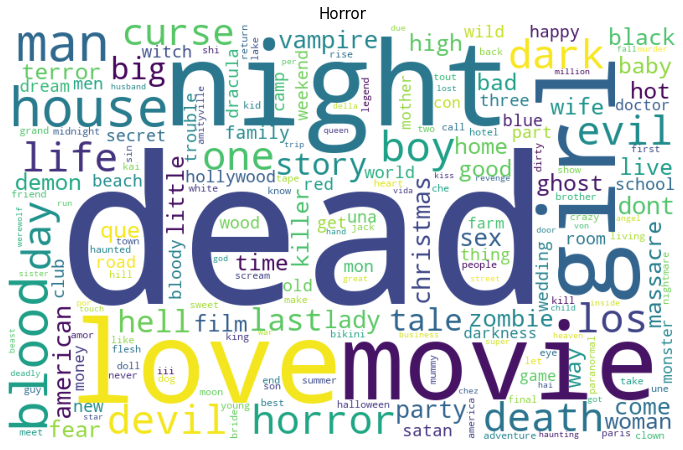

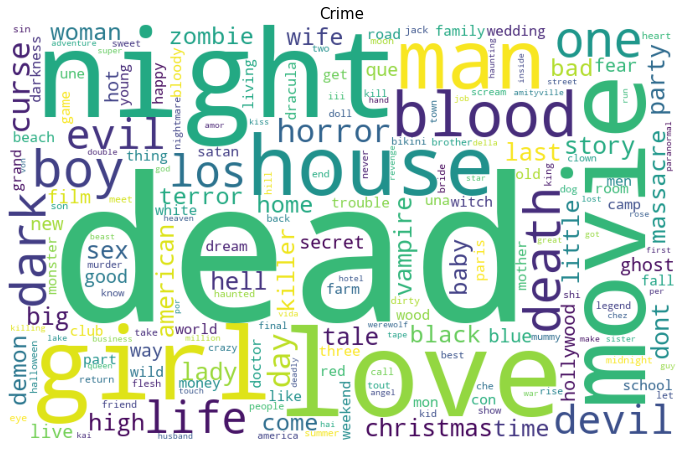

In [58]:
for i,genre in enumerate(genres_list[:3]):
    wordcloud_description = WordCloud(width = 800, height = 500,background_color="white").generate_from_frequencies(fdist_filtered_description[i])
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud_description)
    plt.axis("off")
    plt.title('{}'.format(genre), fontsize=15)
    plt.show()
    #plt.savefig('yourfile.png', bbox_inches='tight')
    plt.close()

## Co-occurrence analysis

In [32]:
genres = dataset['genres'].tolist()

genre_per_movie = []
genre_dict = {}
invalid_genres = ['Game-Show', 'Adult', 'News', 'Reality-TV',
                  '\\N', 'Talk-Show']
for genre in genres:
  #print(genre)
  #genre = ast.literal_eval(genre)
  genre_list = genre.split(',')
  #print(genre_list)
  for val in genre_list:
    if val not in invalid_genres:
      if val in genre_dict:
        genre_dict[val] += 1
      else:
        genre_dict[val] = 1
  genre_per_movie.append(genre_list)
genre_dict = {key:val for key, val in genre_dict.items()}
dataset['genre_list'] = genre_per_movie
dataset['genres'] = dataset['genres'].str.replace(",", " ")

In [11]:
coun_vect = CountVectorizer(lowercase=False,tokenizer=lambda x: x.split(' '))
count_matrix = coun_vect.fit_transform(dataset.genres)
count_array = count_matrix.toarray()
df = pd.DataFrame(data=count_array,columns = coun_vect.get_feature_names())
df_asint = df.astype(int)
coocc = df_asint.T.dot(df_asint)

In [14]:
np.fill_diagonal(coocc.values, 0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5]),
 <a list of 23 Text xticklabel objects>)

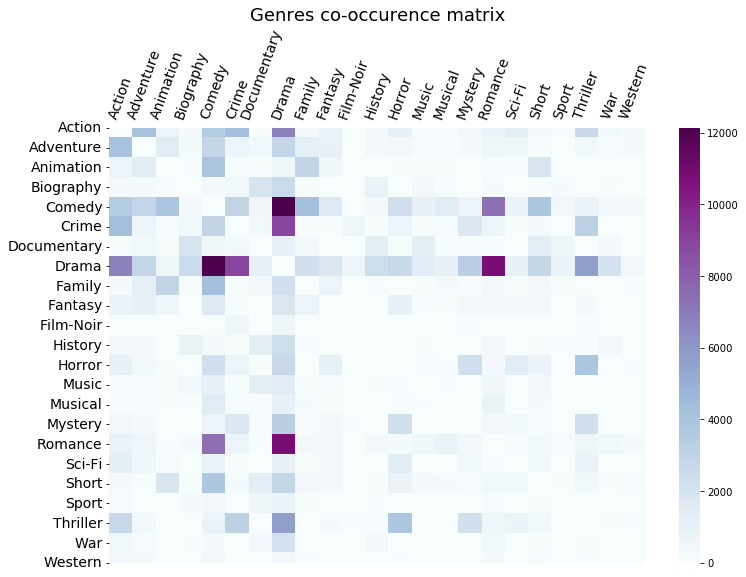

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(coocc, cmap="BuPu")
plt.title("Genres co-occurence matrix",fontsize=18)
plt.tick_params( axis = 'both', which = 'major',labelsize = 14,  labelbottom = False, bottom = False, top=False, labeltop = True)
plt.yticks(fontsize=14)
plt.xticks(rotation = 70, fontsize=14)

In [20]:
labels = {}
for genre in dataset['genre_list']:
  if len(genre) in labels:
    labels[len(genre)] += 1
  else:
    labels[len(genre)] = 1


In [21]:
m = coocc.reset_index()[['index']].rename( columns = {'index':'genre'})
m['max_genre_cooc'] = coocc.idxmax(axis=1).values
m['max_movie_cooc'] = coocc.max(axis=1).values
m['genre_pair'] = m.apply(lambda x: x['genre'] +"-" + x['max_genre_cooc'], axis = 1)
m =m.sort_values(by = 'max_movie_cooc', ascending = False).reset_index(drop = True)

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.]),
 <a list of 8 Text xticklabel objects>)

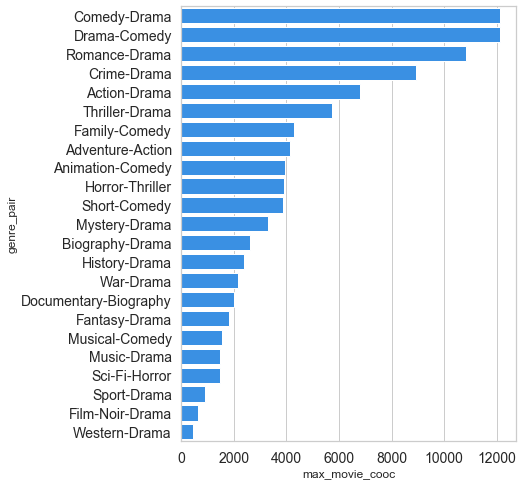

In [79]:

plt.figure(figsize=(6,8))
#clrs = [ 'deeppink' if (x < 5) else 'dodgerblue' for x in m.index.values ]
ax = sns.barplot(y='genre_pair',x= 'max_movie_cooc',  data=m, color = 'dodgerblue')
plt.yticks(fontsize=14)
plt.xticks( fontsize=14)



## Common genres

In [33]:
genre_dict 
keys = list(genre_dict.keys())
values = list(genre_dict.values())

In [34]:
genre_dict 

{'Drama': 66218,
 'Short': 12431,
 'Documentary': 16409,
 'Comedy': 43119,
 'Horror': 14934,
 'Crime': 15480,
 'Mystery': 7464,
 'Action': 18107,
 'Musical': 3195,
 'Animation': 7394,
 'Music': 3901,
 'Biography': 4893,
 'History': 4188,
 'Family': 8216,
 'Fantasy': 5727,
 'Sci-Fi': 5265,
 'Romance': 17736,
 'Adventure': 10586,
 'Thriller': 15817,
 'Sport': 2044,
 'Western': 3476,
 'War': 3207,
 'Film-Noir': 722}

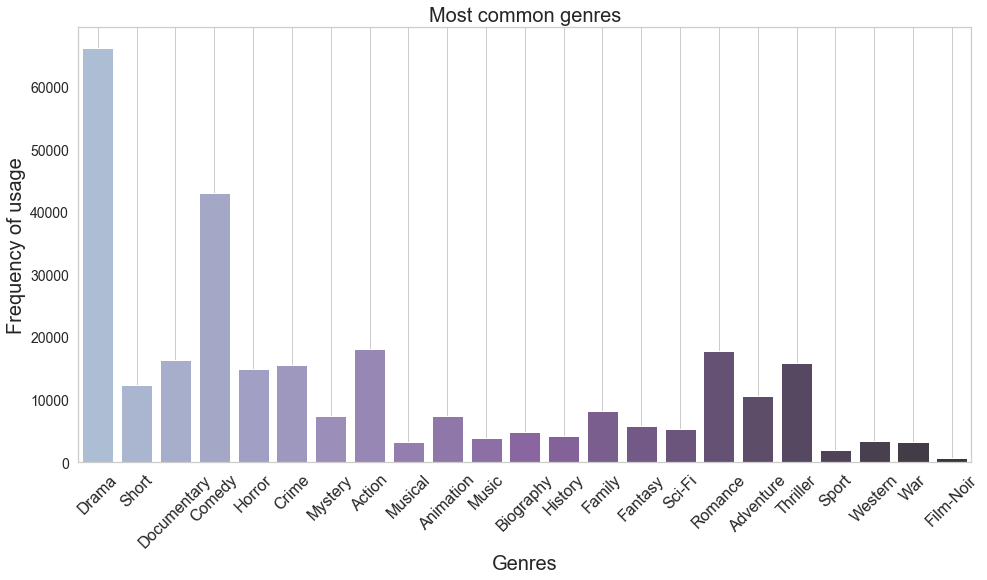

In [78]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.barplot(keys, values, palette=("BuPu_d"))
plt.title("Most common genres", size=20)
plt.ylabel('Frequency of usage', size=20)
plt.xlabel('Genres', size=20)
plt.xticks(size=16)
plt.xticks(rotation=45)
plt.yticks(size=14)
plt.grid()

## Release date

In [81]:
titles_parquet = pd.read_parquet('Titles.parquet') # file with full metadata
merge = dataset.merge(titles_parquet[['id','release_date']], how="inner", on="id")
def preprocess_release_date (rls_date):
  rls_date = str(rls_date) 
  year = None
  month = None 
  day = None
  if rls_date == 'None': 
    pass
  else: 
    m = re.sub(r"[^\w\s]", '',str(rls_date)[:str(rls_date).find('(')]).split()
    if len(m[-1]) == 4 : 
      year = int(m[-1])
    if len(m)>1:
      month = m[0]
    if len(m)>2 : 
      day = int(m[1])
  return year

  merge['year'] = merge.release_date.apply( lambda x: preprocess_release_date (x))

In [99]:
merge['year'] = merge.release_date.apply( lambda x: preprocess_release_date (x))

In [106]:
years = merge.groupby(['year'])['id'].count().reset_index()

In [129]:
years[years['year']>=2010].id.sum()/years.id.sum()

0.40070972421738327

In [124]:
years[years['year']>=2010].id.sum()

56347